In [1]:
import datetime
print('Last updated:', datetime.datetime.now(), '(PT)')

Last updated: 2020-06-05 09:46:11.494924 (PT)


In [2]:
import pystan
import numpy as np
import json
import matplotlib.pyplot as plt

In [3]:
model = """
data{
  int<lower=0> K;  // Number of cluster
  int<lower=0> N;  // Number of observations
  real y[N];  // observations
}

parameters {
  real mu[K]; // cluster means
  // real <lower=0,upper=1> v[K - 1];  // stickbreak components
  vector<lower=0,upper=1>[K - 1] v;  // stickbreak components
  real<lower=0> sigma[K];  // error scale
  real<lower=0> alpha;  // hyper prior DP(alpha,base)
}

transformed parameters{
  simplex [K] eta;
  vector<lower=0,upper=1>[K - 1] cumprod_one_minus_v;

  cumprod_one_minus_v = exp(cumulative_sum(log1m(v)));
  eta[1] = v[1];
  eta[2:(K-1)] = v[2:(K-1)] .* cumprod_one_minus_v[1:(K-2)];
  eta[K] = cumprod_one_minus_v[K - 1];
}

model {
  real ps[K];
  // real alpha = 1;
  
  alpha ~ gamma(1, 10);  // mean = a/b = 1/10
  sigma ~ gamma(1, 10);
  mu ~ normal(0, 3);
  v ~ beta(1, alpha);

  for(i in 1:N){
    for(k in 1:K){
      ps[k] = log(eta[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(ps);
  }
}
"""

In [4]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
  simdata = json.load(f)

In [5]:
# Compile the model.
%time sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ddbcab84ffe9331f0f4171b7e80f2b03 NOW.


CPU times: user 820 ms, sys: 51 ms, total: 871 ms
Wall time: 51.9 s


In [6]:
# Create data dictionary.
data = dict(y=simdata['y'], K=10, N=len(simdata['y']))

# Number of burn in iterations
burn = 500

# Number of sampels to keep
nsamples = 500

# Number of MCMC (HMC / NUTS) iterations in total
niters = burn + nsamples

In [7]:
%%time

# Sample from posterior via NUTS: 1m 57s
fit = sm.sampling(data=data, iter=niters, chains=1, warmup=burn, thin=1, seed=1)

# Sample from posterior via HMC: 53s
# NOTE: num_leapfrog = int_time / stepsize.
# fit = sm.sampling(data=data, iter=niters, chains=1, warmup=burn, thin=1, seed=1,
#                   algorithm='HMC', control=dict(stepsize=0.01, int_time=1))

CPU times: user 1min 57s, sys: 225 ms, total: 1min 57s
Wall time: 1min 57s


In [8]:
def plot_param_post(param_name, param_full_name, figsize=(12, 4)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.boxplot(fit[param_name], whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    # for wk in  simdata['w']:
    #     plt.axhline(wk)

    plt.subplot(1, 2, 2)
    plt.plot(fit[param_name]);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

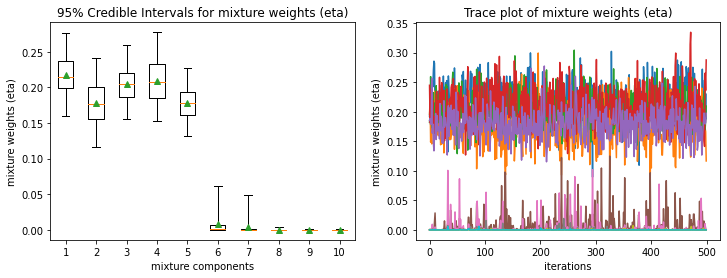

In [9]:
plot_param_post('eta', 'mixture weights (eta)')

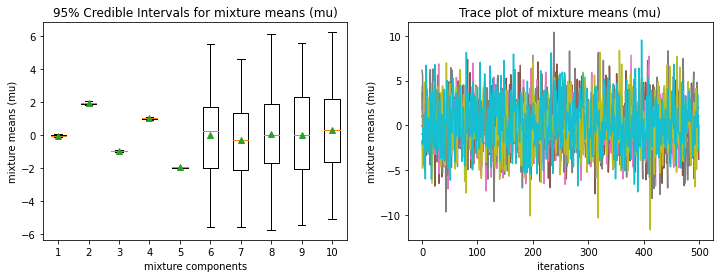

In [10]:
plot_param_post('mu', 'mixture means (mu)')

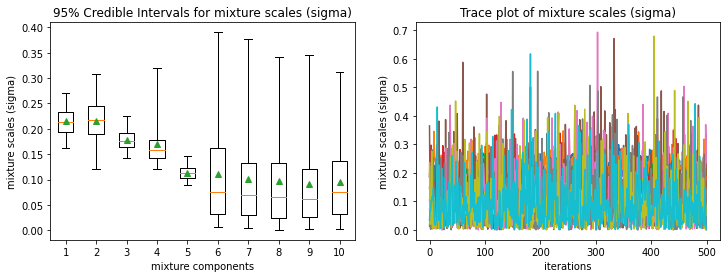

In [11]:
plot_param_post('sigma', 'mixture scales (sigma)')

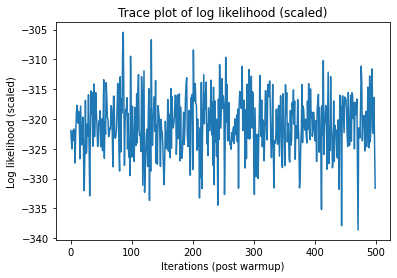

In [12]:
# Plot trace of log likelihood (up to proportionality constant)
plt.plot(fit['lp__'])
plt.xlabel("Iterations (post warmup)")
plt.ylabel("Log likelihood (scaled)");
plt.title('Trace plot of log likelihood (scaled)');

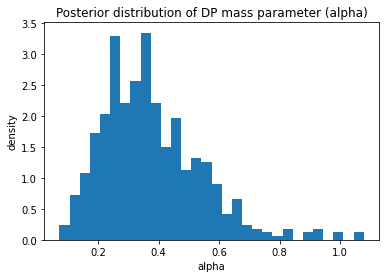

In [13]:
# Plot distribution of alpha
plt.hist(fit['alpha'], bins=30, density=True);
plt.xlabel('alpha')
plt.ylabel('density')
plt.title('Posterior distribution of DP mass parameter (alpha)');